In [2]:
from HGCal_ImageAlgo3D import *
from utility_benchmark import *
from timeit import default_timer as timer

%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

DatasetDir  = '/home/zchen/Documents/ImageAlogrithm3D/data/'
DatasetFile = 'CMSSW93X_pt35_pu000'
#DatasetFile ='CMSSW9304_partGun_PDGid22_x100_E30.0To30.0_NTUP'

Welcome to JupyROOT 6.10/00


In [3]:
df = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_rechit.pkl")
dfgen = pd.read_pickle(DatasetDir+"input/"+DatasetFile+"_gen.pkl")

# 1. Define Fitness

In [8]:
def TranslateDNA(DNA):
    para_upper = np.array([2,8,8,5])
    para_lower = np.array([0,2,2,2])
    para = DNA*(para_upper-para_lower)+para_lower
    return para

def DefineFitness(DNA):
    para = TranslateDNA(DNA)
    ia=ImagingAlgo3D(MAXDISTANCE        = 200,  #cm
                     LAYER_DISTANCE     = para[0], #1.2,  #cm
                     KERNAL_R           = para[1], #4.0,  #cm
                     KERNAL_R_NORM      = para[2], #2.0,  #cm
                     KERNAL_R_POWER     = 2.0,  #cm
                     KERNAL_LAYER       = 2.0,  #number of layer
                     DECISION_RHO_KAPPA = 10.0, #fractio of max rho
                     DECISION_NHD       = para[3], #4.0,  #cm
                     CONTINUITY_NHD     = 6.0   #cm 
                    )

    dfresultclus = ia.RunImagingAlgo(df,Nevent=100,verb=False)
    bm = Benchmark(DatasetFile, dfresultclus, N=100)
    sigma,mean = bm.getEffSigma_EnergyEfficiency(deltarho = 10)
    
    fitness = 1/sigma
    return fitness

# 2. Define GA and Optimize

In [9]:
from GeneticOptimizer import *
from IPython.display import clear_output

ga = GA(pop_size    = 100,
        DNA_size    = 4, 
        DNA_fitness = DefineFitness,
        cross_rate  = 0.8,
        mutate_rate = 0.01,
        noise_rate  = 0.4,
        noise_amp   = 0.02
       )


In [ ]:
fitness_list = []
best_para_list = []
for generation in range(2):
    print(generation)
    clear_output(wait=True)
    
    ga.evolve()
    fitness  = ga.get_pop_fitness()
    best_DNA = ga.pop[np.argmax(fitness)]
    fitness_list.append(fitness)
    best_para_list.append(TranslateDNA(best_DNA))
np.save('../data/fitness_pu000',np.array(fitness_list))
np.save('../data/bestpara_pu000',np.array(best_para_list))

0


In [7]:
f = np.load('../data/fitness_pu000_100.npy')
p = np.load('../data/bestpara_pu000_100.npy')

Text(0,0.5,'$\\sigma^{eff}_\\epsilon$')

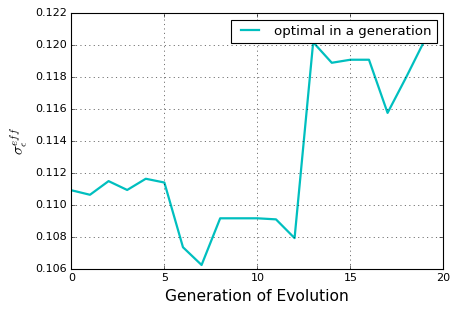

In [10]:
sigma = 1/(np.max(f,axis=1))
#sigma = sigma.reshape(-1,2)
#sigma = np.mean(sigma, axis=1)
evolve = np.arange(0,20,1)
plt.plot(evolve,sigma,'c',lw=2,label='optimal in a generation')
#plt.plot(evolve,sigma_pred,'k--',lw=1)
#plt.axhline(0.1165)
plt.legend()
plt.grid()
plt.xlabel('Generation of Evolution',fontsize=14)
plt.ylabel(r'$\sigma^{eff}_\epsilon$',fontsize=14)
#plt.savefig('../plot/ga.png',dpi=300)

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
regr = linear_model.LinearRegression()
regr.fit(evolve[:,None], sigma)
sigma_pred = regr.predict(evolve[:,None])

In [214]:
p[49]

array([ 0.16684826,  2.26653517,  5.22033166,  2.48411659])

# Debug

In [157]:
def TranslateDNA(DNA):
    para_upper = np.array([10])
    para_lower = np.array([0])
    para = DNA*(para_upper-para_lower)+para_lower
    return para
def func(x):
    return -3*np.cos(10*x/np.pi) + x*(10-x) + 4
def DefineFitness(DNA):
    para = TranslateDNA(DNA)
    x = para[0]
    fitness = func(x)
    return fitness

In [163]:
ga = GA(pop_size    = 100,
        DNA_size    = 1, 
        DNA_fitness = DefineFitness,
        cross_rate  = 0.8,
        mutate_rate = 0.03,
        noise_rate  = 0.1,
        noise_amp   = 0.02
       )

In [164]:
fitness_list = []
para_list = []
for generation in range(100):
    print(generation)
    clear_output(wait=True)
    
    ga.evolve()
    
    para_list.append(TranslateDNA(ga.pop))
    fitness  = ga.get_pop_fitness()
    fitness_list.append(fitness)

fitness_list= np.array(fitness_list)
para_list = np.array(para_list)

99


In [165]:
plt.style.use('dark_background')
plt.rc("figure",facecolor="k",figsize=(6,4))

In [166]:
for i in range(0,100,2):
    x = np.linspace(0,10,100)
    plt.plot(x,func(x),'gray',lw=2)
    pop = para_list[i]
    plt.scatter(pop,func(pop),edgecolor='None',color='c',s=100,alpha=0.5)
    plt.xlabel('parameter')
    plt.ylabel('fitness')
    plt.grid(True)
    plt.xlim(0,10)
    plt.ylim(5,40)
    plt.title("generation {}".format(i))
    plt.savefig('../plot/generation_{}.png'.format(i))
    plt.close()

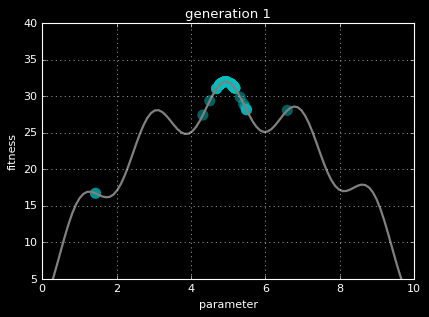

In [168]:
x = np.linspace(0,10,100)
plt.plot(x,func(x),'gray',lw=2)
pop = para_list[-1]
plt.scatter(pop,func(pop),edgecolor='none',color='c',s=100,alpha=0.5)
plt.xlabel('parameter')
plt.ylabel('fitness')
plt.grid(True)
plt.xlim(0,10)
plt.ylim(5,40)
plt.title("generation {}".format(1))
plt.savefig('../plot/generation_{}.png'.format(1))